# Develop neural network modified mean field microkinetic modeling framework

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import casadi as cas

In [2]:
Rg = 8.314

In [3]:
# Kinetic parameter
alpha = 1.6
gamma = 0.001
kr = 1
T = 500
eps = 8368       #cal/mol
Z = 4          # coordination number
omega = 1      # reaction proximity

In [4]:
def cal_steadystate(model, betas=np.arange(0, 12, 0.01), restart=20):
    opts = dict(t0=0, tf=1e6)
    opts["abstol"] = 1e-12
    opts["reltol"] = 1e-8
    fint = cas.integrator('fint', 'cvodes', model, opts)
    
    covList = []
    for b in betas:
        covs = []
        for i in range(restart):   # 10 starting points
            c0 = np.random.uniform(0, 1)
            cc = [c0, np.random.uniform(0, 1) * (1 - c0)]
            try:
#                 cov = rf(x0=cc, p=b)['x'].full().T[0]
                cov = fint(x0=cc, p=b)['xf'].full().T[0]
                flag = True
                if covs == []:
                    flag = True
                else:
                    for c in covs:
                        if np.allclose(c, cov, rtol=1e-06, atol=1e-06):
                            flag = False
                if flag:
                    covs.append(cov)
            except:
                pass
        covList.append(covs)
    return covList, betas

In [5]:
def cal_steadystate_rf(model, betas=np.arange(0, 12, 0.01), restart=20):
    
    x, g, p = model['x'], model['g'], model['p']
    jac = cas.jacobian(g, x)
    
    def isstable(sol, beta):
        func = cas.Function('func', [x, p], [jac])
        j = func(sol, beta)
        eigv = np.linalg.eigvals(j)

        if (eigv <= 0).all():
            return True
        else:
            return False

    opts = {}
    opts["abstol"] = 1e-40
    opts["show_eval_warnings"] = False
    # opts["verbose"] = True
#     opts["error_on_fail"] = False
    # opts["linear_solver"] = "csparse"
    
    rf = cas.rootfinder('G','newton', model, opts)
    covList, stableList = [], []
    for b in betas:
#         print("Beta = %.3f" % b)
        covs, stable = [], []
        for i in range(restart):   # 10 starting points
            c0 = np.random.uniform(0, 1)
            cc = [c0, np.random.uniform(0, 1) * (1 - c0)]
            
            try:
                cov = rf(x0=cc, p=b)['x'].full().T[0]
#                 print(b, cov)
                flag = True
                if covs == []:
                    flag = True
                else:
                    for c in covs:
                        if np.allclose(c, cov, rtol=1e-04, atol=1e-04):
                            flag = False
                if flag and ((np.array(cov) >= -1e-3).all() and (np.array(cov) <= 1).all() and (np.sum(cov) <= 1)):
                    # determine the stability of the solution
                    stable.append(isstable(cov, b))
                    covs.append(cov)
            except:
                pass
        covList.append(covs)
        stableList.append(stable)
    return covList, betas, stableList




In [6]:
# plot coverages vs beta

def plot_coverage(coverages, betas, index=0, stables=[]):
    
    fig = plt.figure(dpi=200, figsize=(3, 2.5))
    ax  = fig.gca()
    if stables != []:
        for cov, beta, stab in zip(coverages, betas, stables):
            for c, st in zip(cov, stab):
                if st:
                    ax.plot(beta, c[index], 'ro', ms=4)
                else:
                    ax.plot(beta, c[index], 'b^', ms=4)
    else:
        for cov, beta in zip(coverages, betas):
            for c in cov:
                ax.plot(beta, c[index], 'ro', ms=4)

    ax.set_xlabel(r'$\beta$ (s$^{-1}$)', fontsize=8)
    ax.set_ylabel(r'$\theta_%s$' %index, fontsize=8)
    ax.tick_params(which='both', direction='in', labelsize=6)

# Mean Field Model
\begin{align}
\frac{d\theta_{CO}}{dt} &= \alpha\theta^* - \gamma\theta_{CO} - k_r(2\theta_{CO}\theta_{O}) \\
\frac{d\theta_{O}}{dt} &= 2\beta\theta^*\theta^* - k_r(2\theta_{CO}\theta_{O})
\end{align}

In [9]:
CO = cas.SX.sym('CO', 1)
O = cas.SX.sym('O', 1)
beta = cas.SX.sym('beta', 1)


free = 1 - CO - O
dCO = alpha * free \
      - gamma * CO \
      - kr * (Z * CO * O)

dO = Z * beta * free * free \
     - kr * (Z * CO * O)

x = cas.vertcat(CO, O)
dx = cas.vertcat(dCO, dO)



In [19]:
import time

def singleMF():
    eqn = dict(x=x, ode=dx, p=beta)
    # measure MKM time
    opts = dict(t0=0, tf=50)
    opts["abstol"] = 1e-12
    opts["reltol"] = 1e-8
    fint = cas.integrator('fint', 'cvodes', eqn, opts)
    xf = fint(x0=[0.9, 0.0], p=[5])

n = 10000
tic = time.time()

for i in range(n):
    singleMF()
toc = time.time()
print((toc - tic) / float(n))

0.001468690848350525


In [ ]:
eqn = dict(x=x, g=dx, p=beta)

covlist, betas, stableList = cal_steadystate_rf(eqn)
plot_coverage(covlist, betas, index=0, stables=stableList)


In [ ]:
# order the list based on beta
datas1 = []
datas2 = []
datas3 = []
for covs, beta, stables in zip(covlist, betas, stableList):
    for cov, stable in zip(covs, stables):
        data = {}
        data['coverage'] = list(cov)
        data['beta'] = beta
        data['stable'] = stable
        if stable and cov[0] >= 0.4:
            datas1.append(data)
        if not stable and cov[0] >= 0.1:
            datas2.append(data)
        if stable and cov[0] <= 0.5 and cov[0]>= 1e-2:
            datas3.append(data)

datas = {}
datas['stable1'] = datas1
datas['stable2'] = datas3
datas['unstable'] = datas2
# datas = datas1 + datas2[::-1] + datas3
import json
with open('mf.json', 'w') as fp:
    json.dump(datas, fp, indent=4)

# Mean field 

In [8]:
CO = cas.SX.sym('CO', 1)
O = cas.SX.sym('O', 1)
beta = cas.SX.sym('beta', 1)


free = 1 - CO - O
dCO = alpha * free \
      - gamma * CO \
      - kr * (Z * CO * O)

dO = Z * beta * free * free \
     - kr * (Z * CO * O)

x = cas.vertcat(CO, O)
dx = cas.vertcat(dCO, dO)

ode = dict(x=x, ode=dx, p=beta)

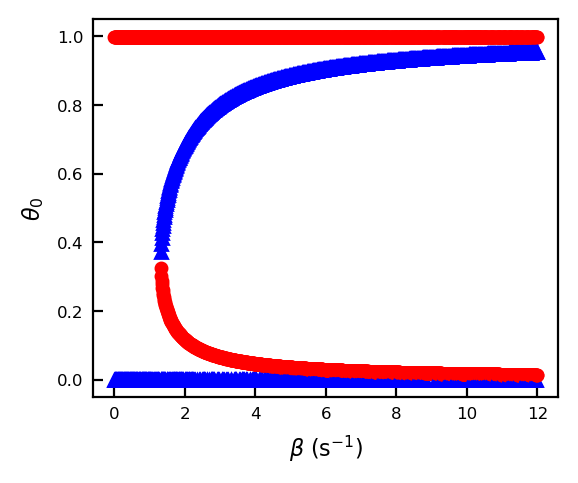

In [9]:
eqn = dict(x=x, g=dx, p=beta)

covlist, betas, stableList = cal_steadystate_rf(eqn)
plot_coverage(covlist, betas, index=0, stables=stableList)

In [10]:
# order the list based on beta
datas1 = []
datas2 = []
datas3 = []
for covs, beta, stables in zip(covlist, betas, stableList):
    for cov, stable in zip(covs, stables):
        data = {}
        data['coverage'] = list(cov)
        data['beta'] = beta
        data['stable'] = stable
        if stable and cov[0] >= 0.4:
            datas1.append(data)
        if not stable and cov[0] >= 0.1:
            datas2.append(data)
        if stable and cov[0] <= 0.5 and cov[0]>= 1e-2:
            datas3.append(data)

datas = {}
datas['stable1'] = datas1
datas['stable2'] = datas3
datas['unstable'] = datas2
# datas = datas1 + datas2[::-1] + datas3
import json
with open('mf.json', 'w') as fp:
    json.dump(datas, fp, indent=4)

# Mean Field Model with vary Activation barrier

\begin{align}
\frac{d\theta_{CO}}{dt} &= \alpha\theta^* - \gamma\theta_{CO}exp(\frac{\omega Z\epsilon}{RT}) - k_r(2\theta_{CO}\theta_{O})exp(\frac{\omega (Z-1)\epsilon}{RT}) \\
\frac{d\theta_{O}}{dt} &= 2\beta{\theta*}^2 - k_r(2\theta_{CO}\theta_{O})exp(\frac{\omega (Z-1)\epsilon}{RT})
\end{align}


In [20]:
CO = cas.SX.sym('CO', 1)
O = cas.SX.sym('O', 1)
beta = cas.SX.sym('beta', 1)


free = 1 - CO - O
dCO = alpha * free \
      - gamma * CO * cas.exp(omega * Z * CO * eps / (Rg * T)) \
      - kr * (Z * CO * O) * cas.exp(omega * (Z - 1) * CO * eps/ (Rg * T))

dO = Z * beta * free * free \
     - kr * (Z * CO * O) * cas.exp(omega * (Z - 1) * CO * eps / (Rg * T))

x = cas.vertcat(CO, O)
dx = cas.vertcat(dCO, dO)

ode = dict(x=x, ode=dx, p=beta)

In [21]:
import time

def singleMF():
    eqn = dict(x=x, ode=dx, p=beta)
    # measure MKM time
    opts = dict(t0=0, tf=50)
    opts["abstol"] = 1e-12
    opts["reltol"] = 1e-8
    fint = cas.integrator('fint', 'cvodes', eqn, opts)
    xf = fint(x0=[0.9, 0.0], p=[5])

n = 10000
tic = time.time()

for i in range(n):
    singleMF()
toc = time.time()
print((toc - tic) / float(n))

0.0021077298879623413


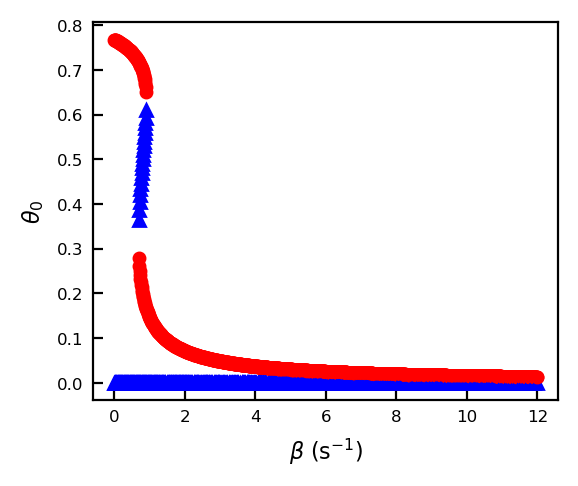

In [12]:
eqn = dict(x=x, g=dx, p=beta)

covlist, betas, stableList = cal_steadystate_rf(eqn)
plot_coverage(covlist, betas, index=0, stables=stableList)



In [13]:
# order the list based on beta
datas1 = []
datas2 = []
datas3 = []
for covs, beta, stables in zip(covlist, betas, stableList):
    for cov, stable in zip(covs, stables):
        data = {}
        data['coverage'] = list(cov)
        data['beta'] = beta
        data['stable'] = stable
        if stable and cov[0] >= 0.4:
            datas1.append(data)
        if not stable and cov[0] >= 0.1:
            datas2.append(data)
        if stable and cov[0] <= 0.5 and cov[0]>= 1e-2:
            datas3.append(data)

datas = {}
datas['stable1'] = datas1
datas['stable2'] = datas3
datas['unstable'] = datas2
# datas = datas1 + datas2[::-1] + datas3
import json
with open('mf-ea.json', 'w') as fp:
    json.dump(datas, fp, indent=4)

In [ ]:
datas2

In [ ]:
# covlist, betas = cal_steadystate(ode)
# plot_coverage(covlist, betas, index=0)
# plot_coverage(covlist, betas, index=1)

In [ ]:
# # Simulate the system and see when to reach the steady state
# b = 1

# tspan = np.linspace(0, 5, 1000)

# clist = []
# for i, t in enumerate(tspan):
#     if i == 0:
#         c = np.array([0, 0])
#     else:
#         opts = dict(t0=tspan[i - 1], tf=t)
#         fint = cas.integrator('fint', 'cvodes', ode, opts)
#         c = fint(x0=c, p=b)['xf']
#         c = c.full().T[0]
#     clist.append(c)

# clist = np.array(clist)

In [ ]:
# fig = plt.figure(dpi=200, figsize=(2.5, 2))
# ax = fig.gca()
# ax.plot(tspan, clist[:, 0], label=r'$\theta_{CO}$')
# ax.plot(tspan, clist[:, 1], label=r'$\theta_{O}$')
# ax.set_xlabel('time (s)', fontsize=8)
# ax.set_ylabel('coverage', fontsize=8)
# ax.tick_params(which='both', direction='in', labelsize=6)
# ax.legend(fontsize=6)
# ax.set_title(r'$\beta=%.3f$' % b, fontsize=8)

# Mean Field Model with modified reaction propensity

In [22]:
# load model
from caslearn import PCE, load_pce

pce00 = load_pce('pce_00.json')
pce12 = load_pce('pce_12.json')

CO = cas.SX.sym('CO', 1)
O = cas.SX.sym('O', 1)
beta = cas.SX.sym('beta', 1)

xx = cas.vertcat(CO, O)

freefree = pce00.initialize(xx)
COO = pce12.initialize(xx)

# freefree = cas.exp(pce00.initialize(xx))
# COO = cas.exp(pce12.initialize(xx))

free = 1 - CO - O
dCO = alpha * free \
      - gamma * CO * cas.exp(omega * Z * CO * eps / (Rg * T)) \
      -  2 * kr * COO * CO * O * cas.exp(omega * (Z - 1) * CO * eps/ (Rg * T))

dO = 4 * beta * freefree * free * free \
     - 2 * kr * COO * CO * O * cas.exp(omega * (Z - 1) * CO * eps / (Rg * T))

# dCO = alpha * free \
#       - gamma * CO * cas.exp(omega * Z * CO * eps / (Rg * T)) \
#       - 1 * kr * COO *  cas.exp(omega * (Z - 1) * CO * eps/ (Rg * T))

# dO = 2 * beta * freefree  \
#      - 1 * kr * COO * cas.exp(omega * (Z - 1) * CO * eps / (Rg * T))

x = cas.vertcat(CO, O)
dx = cas.vertcat(dCO, dO)

ode = dict(x=x, ode=dx, p=beta)

FileNotFoundError: [Errno 2] No such file or directory: 'pce_00.json'

In [ ]:
omega
Z
eps

In [ ]:
eqn = dict(x=x, g=dx, p=beta)

covlist, betas, stableList = cal_steadystate_rf(eqn)
plot_coverage(covlist, betas, index=0, stables=stableList)

# Mean field model with modified reaction propensity and activation energy

In [23]:
# load model
from caslearn import NN, load_nn

nn_r00 = load_nn('nn_rate_(0, 0).json')
nn_r1 = load_nn('nn_rate_1.json')
nn_r12 = load_nn('nn_rate_(1, 2).json')


CO = cas.SX.sym('CO', 1)
O = cas.SX.sym('O', 1)
beta = cas.SX.sym('beta', 1)

xx = cas.vertcat(CO, O, 1 - CO - O)
free = 1 - CO - O

r00 = nn_r00.initialize(xx)
r1 = nn_r1.initialize(xx)
r12 = nn_r12.initialize(xx)

# freefree = cas.exp(pce00.initialize(xx))
# COO = cas.exp(pce12.initialize(xx))


dCO = alpha * free \
      - gamma * r1 \
      - 4 * kr * r12

dO = 2 * beta * r00 \
     - 4 * kr * r12

x = cas.vertcat(CO, O)
dx = cas.vertcat(dCO, dO)

ode = dict(x=x, ode=dx, p=beta)

FileNotFoundError: [Errno 2] No such file or directory: 'nn_rate_(0, 0).json'

In [ ]:
eqn = dict(x=x, g=dx, p=beta)

covlist, betas, stableList = cal_steadystate_rf(eqn)
plot_coverage(covlist, betas, index=0, stables=stableList)

# Mean field with ML-rate

\begin{equation}
r = k_0 exp(-\frac{\omega \Delta E_a}{RT})<\theta_1 \theta_2> 
\end{equation}

In [24]:
# load model
from caslearn import NN, load_nn

nn_r00 = load_nn('nn_lograte_(0, 0).json')
nn_r1 = load_nn('nn_lograte_1.json')
nn_r12 = load_nn('nn_lograte_(1, 0).json')


CO = cas.SX.sym('CO', 1)
O = cas.SX.sym('O', 1)
beta = cas.SX.sym('beta', 1)

xx = cas.vertcat(1 - CO, CO)
free = 1 - CO - O

r00 = cas.exp(nn_r00.initialize(xx))* free * free
r1 = cas.exp(nn_r1.initialize(xx))* CO
r12 = cas.exp(nn_r12.initialize(xx))* CO * O

# freefree = cas.exp(pce00.initialize(xx))
# COO = cas.exp(pce12.initialize(xx))


dCO = alpha * free \
      - gamma * r1 \
      - 2 * kr * r12

dO = 2 * beta * r00 \
     - 2 * kr * r12

x = cas.vertcat(CO, O)
dx = cas.vertcat(dCO, dO)

ode = dict(x=x, ode=dx, p=beta)

In [25]:
import time

def singleMF():
    eqn = dict(x=x, ode=dx, p=beta)
    # measure MKM time
    opts = dict(t0=0, tf=50)
    opts["abstol"] = 1e-12
    opts["reltol"] = 1e-8
    fint = cas.integrator('fint', 'cvodes', eqn, opts)
    xf = fint(x0=[0.9, 0.0], p=[5])

n = 10000
tic = time.time()

for i in range(n):
    singleMF()
toc = time.time()
print((toc - tic) / float(n))

0.002112331557273865


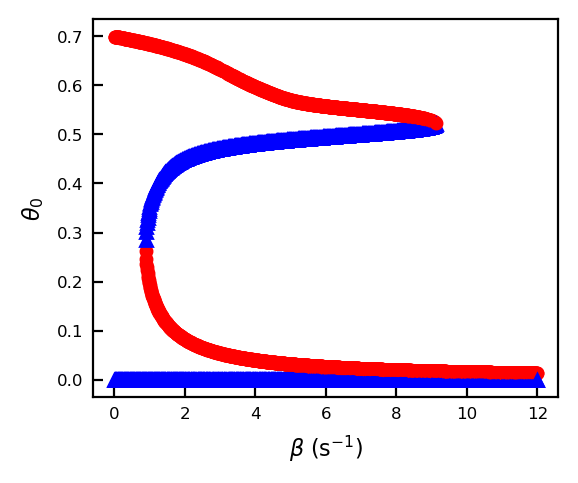

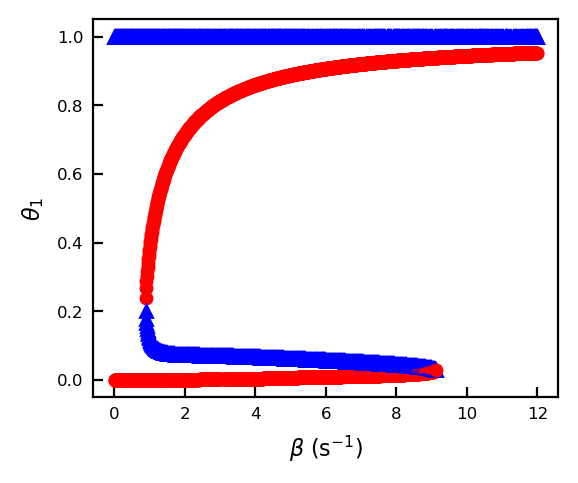

In [18]:
eqn = dict(x=x, g=dx, p=beta)

covlist, betas, stableList = cal_steadystate_rf(eqn)
plot_coverage(covlist, betas, index=0, stables=stableList)
plot_coverage(covlist, betas, index=1, stables=stableList)



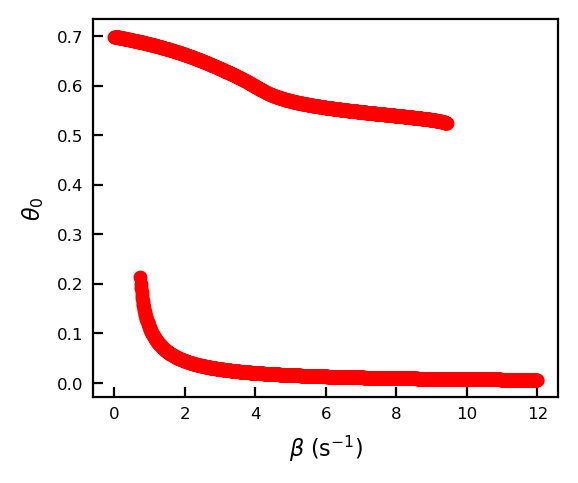

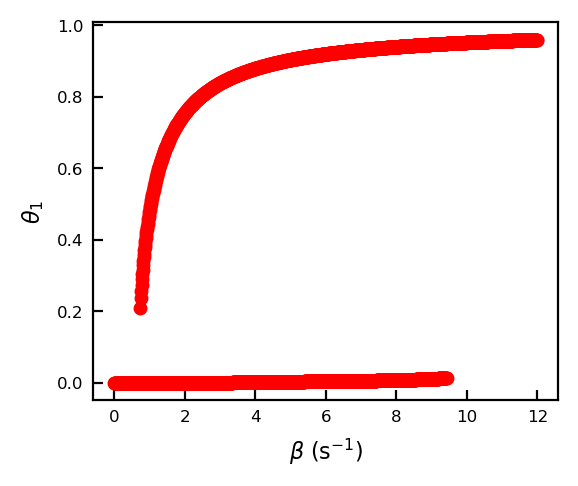

In [9]:
eqn = dict(x=x, ode=dx, p=beta)

covlist, betas= cal_steadystate(eqn)
plot_coverage(covlist, betas, index=0)
plot_coverage(covlist, betas, index=1)

In [19]:
# order the list based on beta
datas1 = []
datas2 = []
datas3 = []
for covs, beta, stables in zip(covlist, betas, stableList):
    for cov, stable in zip(covs, stables):
        data = {}
        data['coverage'] = list(cov)
        data['beta'] = beta
        data['stable'] = stable
        if stable and cov[0] >= 0.4:
            datas1.append(data)
        if not stable and cov[0] >= 0.1:
            datas2.append(data)
        if stable and cov[0] <= 0.5 and cov[0]>= 1e-4:
            datas3.append(data)
datas = {}
datas['stable1'] = datas1
datas['stable2'] = datas3
datas['unstable'] = datas2
# datas = datas1 + datas2[::-1] + datas3
import json
with open('mf-nn.json', 'w') as fp:
    json.dump(datas, fp, indent=4)

In [ ]:
datas


In [ ]:
# load model
from caslearn import PCE, load_pce

pce_r00 = load_pce('pce_lograte_(0, 0).json')
pce_r1 = load_pce('pce_lograte_1.json')
pce_r12 = load_pce('pce_lograte_(1, 2).json')


CO = cas.SX.sym('CO', 1)
O = cas.SX.sym('O', 1)
beta = cas.SX.sym('beta', 1)

xx = cas.vertcat(CO, O)
free = 1 - CO - O

r00 = cas.exp(pce_r00.initialize(xx))* free * free
r1 = cas.exp(pce_r1.initialize(xx))* CO
r12 = cas.exp(pce_r12.initialize(xx))* CO * O

# freefree = cas.exp(pce00.initialize(xx))
# COO = cas.exp(pce12.initialize(xx))


dCO = alpha * free \
      - gamma * r1 \
      - 4 * kr * r12

dO = 2 * beta * r00 \
     - 4 * kr * r12

x = cas.vertcat(CO, O)
dx = cas.vertcat(dCO, dO)

ode = dict(x=x, ode=dx, p=beta)

In [ ]:
eqn = dict(x=x, g=dx, p=beta)

covlist, betas, stableList = cal_steadystate_rf(eqn)
plot_coverage(covlist, betas, index=0, stables=stableList)
plot_coverage(covlist, betas, index=1, stables=stableList)

In [ ]:
eqn = dict(x=x, ode=dx, p=beta)

covlist, betas = cal_steadystate(eqn)
plot_coverage(covlist, betas, index=0)
# plot_coverage(covlist, betas, index=1, stables=stableList)
